## **Download Dataset**

In [1]:
!pip install kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amirhosseinfeiz","key":"5228cdd8a111ac93b8ddde7d70369a5f"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d kmader/mias-mammography

 98% 305M/312M [00:03<00:00, 107MB/s] 
100% 312M/312M [00:03<00:00, 95.4MB/s]


In [5]:
!unzip 'mias-mammography'

Archive:  mias-mammography.zip
  inflating: Info.txt                
  inflating: all-mias.tar.gz         
  inflating: all-mias/Info.txt       
  inflating: all-mias/Licence.txt    
  inflating: all-mias/README         
  inflating: all-mias/mdb001.pgm     
  inflating: all-mias/mdb002.pgm     
  inflating: all-mias/mdb003.pgm     
  inflating: all-mias/mdb004.pgm     
  inflating: all-mias/mdb005.pgm     
  inflating: all-mias/mdb006.pgm     
  inflating: all-mias/mdb007.pgm     
  inflating: all-mias/mdb008.pgm     
  inflating: all-mias/mdb009.pgm     
  inflating: all-mias/mdb010.pgm     
  inflating: all-mias/mdb011.pgm     
  inflating: all-mias/mdb012.pgm     
  inflating: all-mias/mdb013.pgm     
  inflating: all-mias/mdb014.pgm     
  inflating: all-mias/mdb015.pgm     
  inflating: all-mias/mdb016.pgm     
  inflating: all-mias/mdb017.pgm     
  inflating: all-mias/mdb018.pgm     
  inflating: all-mias/mdb019.pgm     
  inflating: all-mias/mdb020.pgm     
  inflating: all-mi

In [6]:
# Find the direction of dataset
'''import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

"import numpy as np\nimport pandas as pd\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [7]:
import cv2
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
from keras import optimizers
from keras import losses
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import random # for visualization
print('Libraries Imported')

Libraries Imported


In [8]:
path = 'all-mias/'

an example of image path

../input/mias-mammography/all-mias/mdb001.pgm

## Read Data

In [9]:
import pandas as pd

print("reading dataframe")
info=pd.read_csv("Info.txt",sep=" ")
info=info.drop('Unnamed: 7',axis=1)

reading dataframe


In [10]:
info

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477.0,133.0,30.0
...,...,...,...,...,...,...,...
325,mdb318,D,NORM,NaN,NaN,NaN,NaN
326,mdb319,D,NORM,NaN,NaN,NaN,NaN
327,mdb320,D,NORM,NaN,NaN,NaN,NaN
328,mdb321,D,NORM,NaN,NaN,NaN,NaN


In [11]:
info.dropna(subset = ["SEVERITY"], inplace=True)

info.reset_index(inplace = True)
info

,index,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,4,mdb005,F,CIRC,B,477.0,133.0,30.0
3,5,mdb005,F,CIRC,B,500.0,168.0,26.0
4,10,mdb010,F,CIRC,B,525.0,425.0,33.0
...,...,...,...,...,...,...,...,...
118,281,mdb274,F,MISC,M,127.0,505.0,123.0
119,297,mdb290,D,CIRC,B,337.0,353.0,45.0
120,319,mdb312,F,MISC,B,240.0,263.0,20.0
121,321,mdb314,F,MISC,B,518.0,191.0,39.0


In [12]:
info = info.drop([3], axis=0)
info.reset_index(inplace = True)
info

,level_0,index,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,0,0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,1,1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,2,4,mdb005,F,CIRC,B,477.0,133.0,30.0
3,4,10,mdb010,F,CIRC,B,525.0,425.0,33.0
4,5,12,mdb012,F,CIRC,B,471.0,458.0,40.0
...,...,...,...,...,...,...,...,...,...
117,118,281,mdb274,F,MISC,M,127.0,505.0,123.0
118,119,297,mdb290,D,CIRC,B,337.0,353.0,45.0
119,120,319,mdb312,F,MISC,B,240.0,263.0,20.0
120,121,321,mdb314,F,MISC,B,518.0,191.0,39.0


In [13]:
# taking the images filenames in to dictionary
ids = {}
for i in range(len(info)):
    ids[i] = info.REFNUM[i]
#ids

## Turning our outputs B-M to 1-0

In [14]:
import numpy as np

# Turning our outputs B-M to 1-0
label = []
for i in range(len(info)):
    if info.SEVERITY[i] == 'B':
        label.append(1)
    else:
        label.append(0)

In [15]:
label = np.array(label)

In [16]:
label.shape

(122,)

In [17]:
# define the every images filepaths in to list
img_name = []

for i in range(len(label)):
        img_name.append(path + info.REFNUM[i]+ '.pgm')

In [18]:
img_name = np.array(img_name)

In [19]:
#print(img_name)
print(f'image addres amount {img_name.shape}')

image addres amount (122,)


## **Images Histogram**

In [ ]:
# view image random images
def view_25_random_image(rand):
    fig = plt.figure(figsize = (15, 10))
    for i in range(25):
        ax = plt.subplot(5, 5, i+1)
    
        img = cv2.imread(img_name[rand], 0)
        img = cv2.resize(img, (256,256))
        if label[rand] == 1:
            plt.title('B')
        else:
            plt.title('M')
        plt.tight_layout()
        plt.axis('off')
        plt.imshow(img)
    fig.savefig('random_25_image_fig.png')

random_images = view_25_random_image(rand)

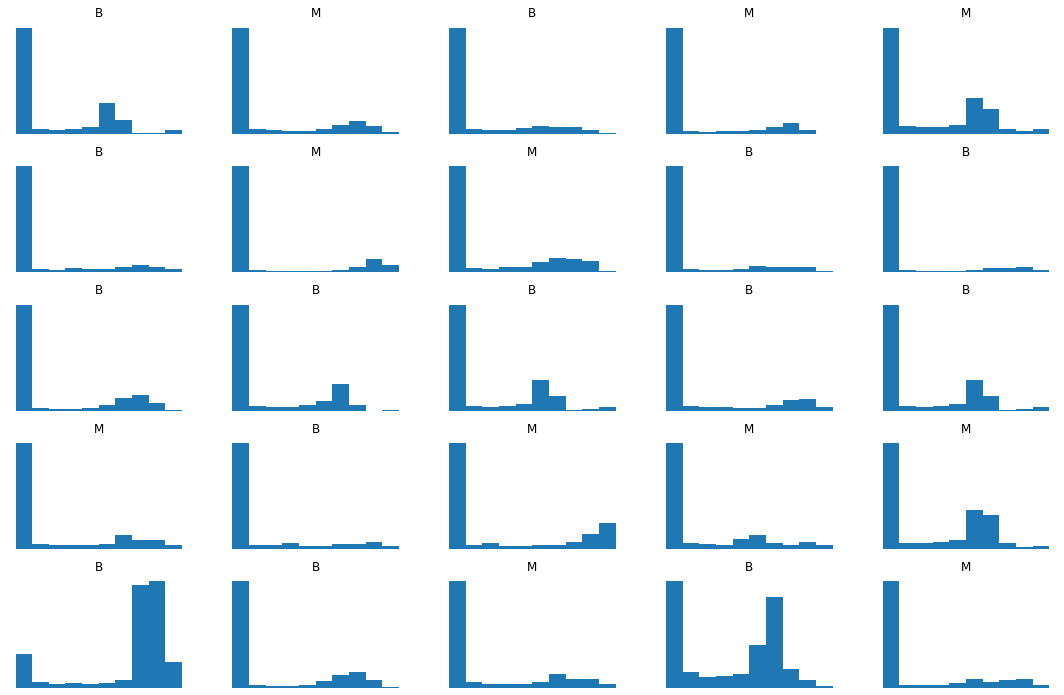

In [20]:
def view_25_random_image_hist():
    fig = plt.figure(figsize = (15, 10))
    for i in range(25):
        rand = random.randint(0,len(label))
        ax = plt.subplot(5, 5, i+1)
    
        img = cv2.imread(img_name[rand], 0)
        img = cv2.resize(img, (256,256))
        if label[rand] == 1:
            plt.title('B')
        else:
            plt.title('M')
        plt.tight_layout()
        plt.axis('off')
        plt.hist(img.ravel())



random_images = view_25_random_image_hist()

## view image random images

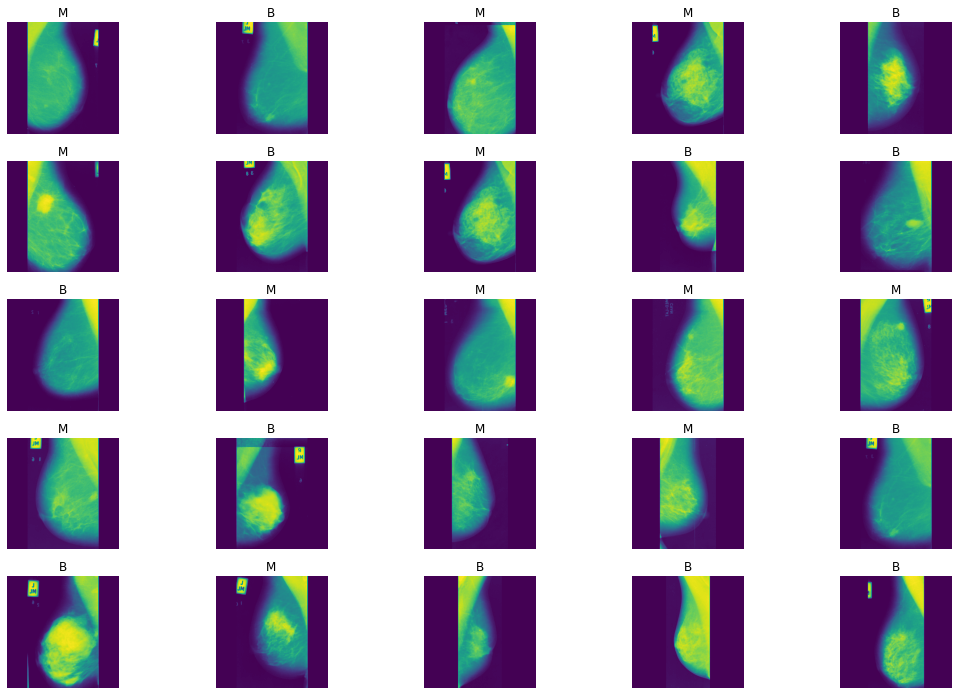

In [21]:
# view image random images
def view_25_random_image():
    fig = plt.figure(figsize = (15, 10))
    for i in range(25):
        rand = random.randint(0,len(label))
        ax = plt.subplot(5, 5, i+1)
    
        img = cv2.imread(img_name[rand], 0)
        img = cv2.resize(img, (256,256))
        if label[rand] == 1:
            plt.title('B')
        else:
            plt.title('M')
        plt.tight_layout()
        plt.axis('off')
        plt.imshow(img)
    fig.savefig('random_25_image_fig.png')

random_images = view_25_random_image()

## **Thresholding**

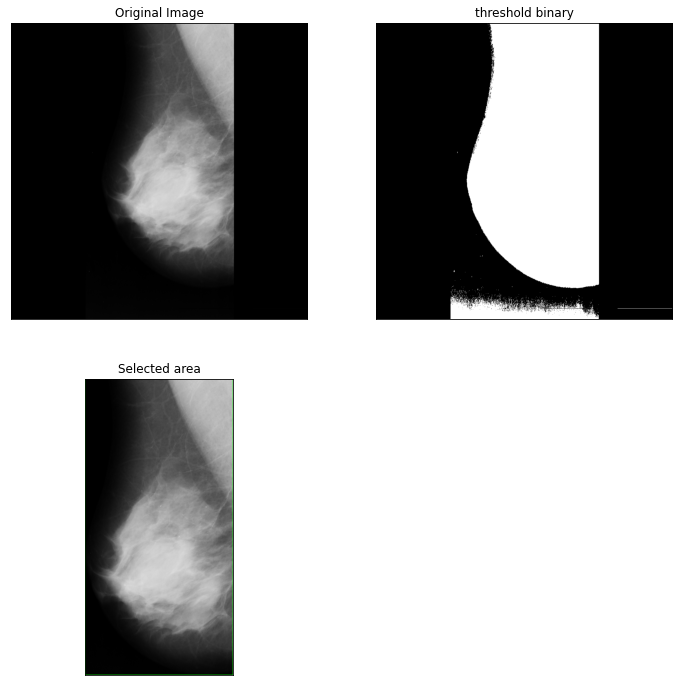

In [23]:
import copy
import cv2
from PIL import Image
from matplotlib import pyplot as plt


IMG_IN = 'mdb001.png'


# keep a copy of original image
original = cv2.imread(IMG_IN)

# Read the image, convert it into grayscale, and make in binary image for threshold value of 1.
img = cv2.imread(IMG_IN,0)

# use binary threshold, all pixel that are beyond 3 are made white
_, thresh_original = cv2.threshold(img, 3, 255, cv2.THRESH_BINARY)

# Now find contours in it.
thresh = copy.copy(thresh_original)
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

# get contours with highest height
lst_contours = []
for cnt in contours:
    ctr = cv2.boundingRect(cnt)
    lst_contours.append(ctr)
x,y,w,h = sorted(lst_contours, key=lambda coef: coef[3])[-1]


# draw contours
ctr = copy.copy(original)
cv2.rectangle(ctr, (x,y),(x+w,y+h),(0,255,0),2)

crop_img = ctr[y:y+h, x:x+w]


# display results with matplotlib

plt.figure(figsize=(12,12))
# original
original = original[:,:,::-1] # flip color for maptolib display
plt.subplot(221), plt.imshow(original)
plt.title('Original Image'), plt.xticks([]),plt.yticks([])

# Threshold
plt.subplot(222), plt.imshow(thresh_original, cmap='gray')
plt.title('threshold binary'), plt.xticks([]),plt.yticks([])

# selected area for future crop
ctr = ctr[:,:,::-1] # flip color for maptolib display
plt.subplot(223), plt.imshow(crop_img)
plt.title('Selected area'), plt.xticks([]),plt.yticks([])

plt.show()

## **Enhancement**

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab as pylab

In [25]:

from skimage import io
from skimage import color
import cv2

def right_orient_mammogram(image):
    left_nonzero = cv2.countNonZero(image[:, 0:int(image.shape[1]/2)])
    right_nonzero = cv2.countNonZero(image[:, int(image.shape[1]/2):])
    
    if(left_nonzero < right_nonzero):
        image = cv2.flip(image, 1)

    return image

def read_image(filename):
    image = io.imread(filename)
    image = color.rgb2gray(image)
    image = right_orient_mammogram(image)
    return image

In [26]:
from skimage.feature import canny
from skimage.filters import sobel

def apply_canny(image):
    canny_img = canny(image, 5,10)
    return sobel(canny_img)

In [27]:
from skimage.transform import hough_line, hough_line_peaks

def get_hough_lines(canny_img):
    h, theta, d = hough_line(canny_img)
    lines = list()
    print('\nAll hough lines')
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        print("Angle: {:.2f}, Dist: {:.2f}".format(np.degrees(angle), dist))
        x1 = 0
        y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
        x2 = canny_img.shape[1]
        y2 = (dist - x2 * np.cos(angle)) / np.sin(angle)
        lines.append({
            'dist': dist,
            'angle': np.degrees(angle),
            'point1': [x1, y1],
            'point2': [x2, y2]
        })
    
    return lines

In [28]:
def shortlist_lines(lines):
    MIN_ANGLE = 10
    MAX_ANGLE = 70
    MIN_DIST  = 5
    MAX_DIST  = 200
    
    shortlisted_lines = [x for x in lines if 
                          (x['dist']>=MIN_DIST) &
                          (x['dist']<=MAX_DIST) &
                          (x['angle']>=MIN_ANGLE) &
                          (x['angle']<=MAX_ANGLE)
                        ]
    print('\nShorlisted lines')
    for i in shortlisted_lines:
        print("Angle: {:.2f}, Dist: {:.2f}".format(i['angle'], i['dist']))
        
    return shortlisted_lines

In [29]:
from skimage.draw import polygon

def remove_pectoral(shortlisted_lines):
    shortlisted_lines.sort(key = lambda x: x['dist'])
    pectoral_line = shortlisted_lines[0]
    d = pectoral_line['dist']
    theta = np.radians(pectoral_line['angle'])
    
    x_intercept = d/np.cos(theta)
    y_intercept = d/np.sin(theta)
    
    return polygon([0, 0, y_intercept], [0, x_intercept, 0])

In [30]:
def display_image(filename):
    image = read_image(filename)
    canny_image = apply_canny(image)
    lines = get_hough_lines(canny_image)
    shortlisted_lines = shortlist_lines(lines)
    
    fig, axes = plt.subplots(1, 4, figsize=(15,10))
    fig.tight_layout(pad=3.0)
    plt.xlim(0,image.shape[1])
    plt.ylim(image.shape[0])
    
    
    axes[0].set_title('Right-oriented mammogram')
    axes[0].imshow(image, cmap=pylab.cm.gray)
    axes[0].axis('on') 
    
    axes[1].set_title('Hough Lines on Canny Edge Image')
    axes[1].imshow(canny_image, cmap=pylab.cm.gray)
    axes[1].axis('on')
    axes[1].set_xlim(0,image.shape[1])
    axes[1].set_ylim(image.shape[0])
    for line in lines:
        axes[1].plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')
        
    axes[2].set_title('Shortlisted Lines')
    axes[2].imshow(canny_image, cmap=pylab.cm.gray)
    axes[2].axis('on')
    axes[2].set_xlim(0,image.shape[1])
    axes[2].set_ylim(image.shape[0])
    for line in shortlisted_lines:
        axes[2].plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')
        
    rr, cc = remove_pectoral(shortlisted_lines)
    image[rr, cc] = 0
    axes[3].set_title('Pectoral muscle removed')
    axes[3].imshow(image, cmap=pylab.cm.gray)
    axes[3].axis('on') 
    
    plt.show()


All hough lines
Angle: -0.50, Dist: 251.59

Shorlisted lines


IndexError: ignored

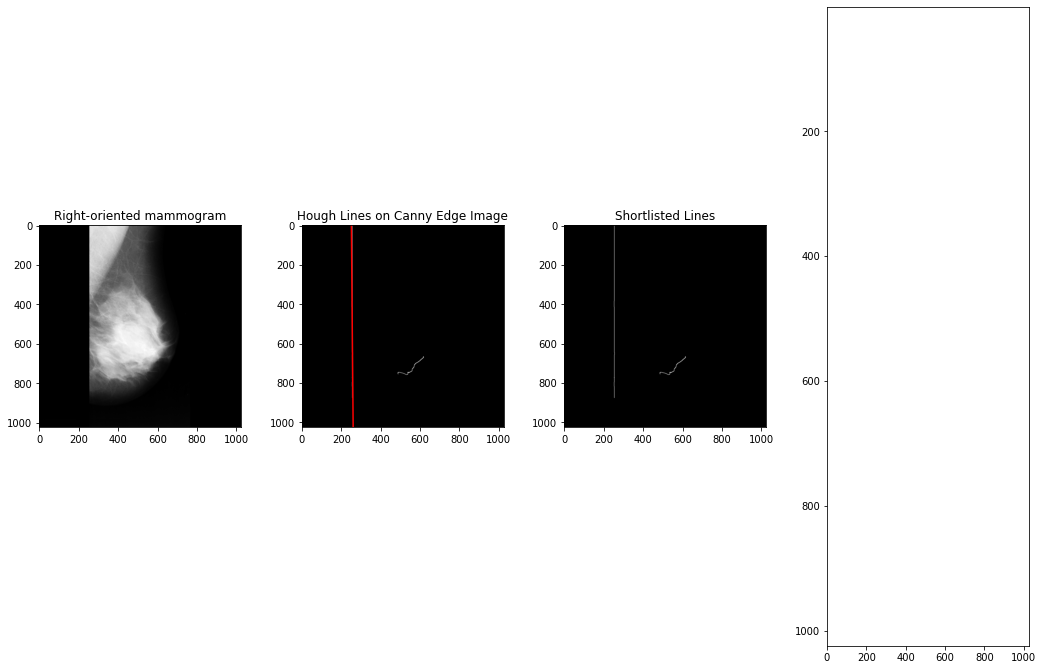

In [31]:
display_image('mdb001.png')

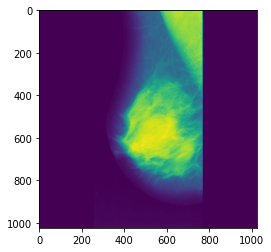

In [32]:
img = plt.imread('mdb001.png')
plt.imshow(img)

## **Simple Segmentation**

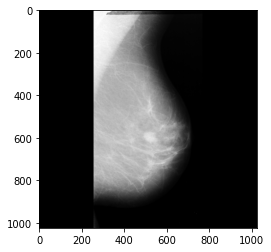

In [33]:
import cv2
import numpy as np

img = cv2.imread(img_name[3],0)

import matplotlib.pyplot as plt

plt.imshow(img, cmap="gray")

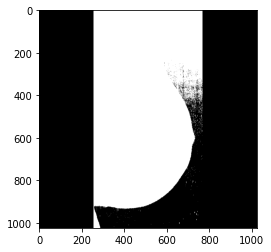

In [34]:
ret,thresh1 = cv2.threshold(img,0,255,cv2.THRESH_BINARY)
plt.imshow(thresh1, cmap="gray")

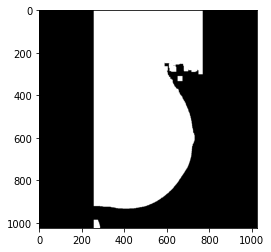

In [35]:
kernel = np.ones((20,20),np.uint8)
opening = cv2.morphologyEx(thresh1, cv2.MORPH_OPEN, kernel)
plt.imshow(opening, cmap="gray")

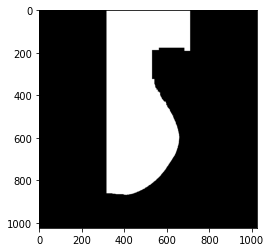

In [36]:
kernel = np.ones((120,120),np.uint8)
erosion = cv2.erode(opening,kernel,iterations = 1)
plt.imshow(erosion, cmap="gray")

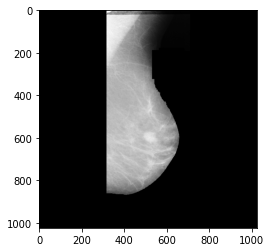

In [37]:
merged = cv2.bitwise_and(img, img , mask=erosion)
plt.imshow(merged, cmap="gray")

In [38]:
import cv2
import numpy as np

In [39]:
img = cv2.imread(img_name[10])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
_,thresh = cv2.threshold(gray,1,255,cv2.THRESH_BINARY)

In [40]:
contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[0]
x,y,w,h = cv2.boundingRect(cnt)

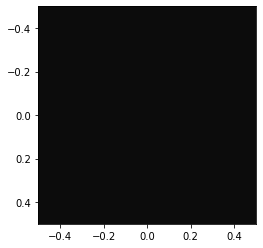

In [41]:
crop = img[y:y+h,x:x+w]
plt.imshow(crop)

## **more Simple Segmentation**

In [42]:
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import img_as_float, img_as_ubyte, io
import numpy as np
from matplotlib import pyplot as plt

In [43]:
img = img_as_float(io.imread(img_name[2]))

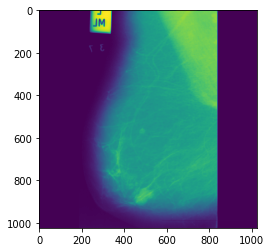

In [44]:
plt.imshow(img)

In [45]:
sigma_est = np.mean(estimate_sigma(img, multichannel=True))

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [46]:
denoise = denoise_nl_means(img, h=1.15*sigma_est, fast_mode=True, patch_size=5, patch_distance=3, multichannel=True)

In [47]:
denoise_ubyte = img_as_ubyte(denoise)

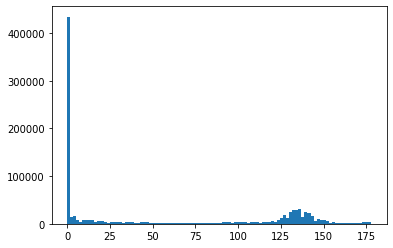

In [48]:
plt.hist(denoise_ubyte.flat, bins=100, range=(0,178))
plt.show()

In [49]:
segm1 = (denoise_ubyte <=80)
segm2 = (denoise_ubyte > 80) & (denoise_ubyte <= 130)
segm3 = (denoise_ubyte > 130)

In [50]:
all_segments = np.zeros((denoise_ubyte.shape[0], denoise_ubyte.shape[1], 3))

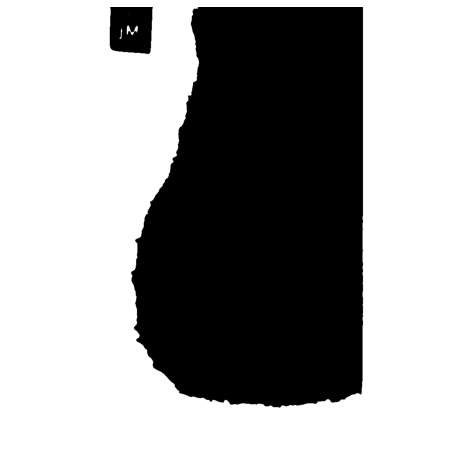

In [51]:
all_segments[segm1] = (1)
all_segments[segm2] = (0)
all_segments[segm3] = (0)
plt.figure(figsize=(8,8))
plt.imshow(all_segments)
plt.axis('off')
plt.show()

## **Apply Different filters**

In [52]:
from skimage.feature import canny
from skimage.filters import sobel
import cv2

def apply_canny(image):
    canny_img = cv2.Canny(image,5,10)
    return sobel(canny_img)

In [53]:
def display(filename):    
    image = read_image(filename)
    canny_image = apply_canny(image)
    '''lines = get_hough_lines(canny_image)
    shortlisted_lines = shortlist_lines(lines)'''
    
    fig, axes = plt.subplots(1, 2, figsize=(15,10))
    fig.tight_layout(pad=3.0)
    plt.xlim(0,image.shape[1])
    plt.ylim(image.shape[0])
    
    
    axes[0].set_title('Right-oriented mammogram')
    axes[0].imshow(image, cmap=pylab.cm.gray)
    axes[0].axis('on') 
    
    axes[1].set_title('Hough Lines on Canny Edge Image')
    axes[1].imshow(canny_image, cmap=pylab.cm.gray)
    axes[1].axis('on')
    axes[1].set_xlim(0,image.shape[1])
    axes[1].set_ylim(image.shape[0])

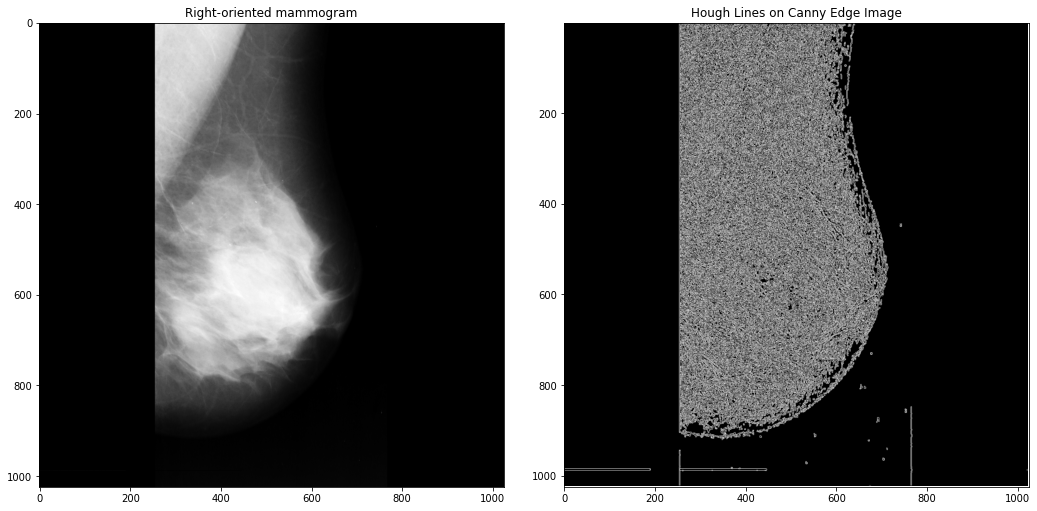

In [54]:
display('mdb001.png')

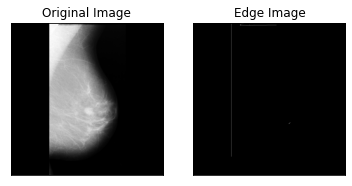

In [55]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = cv.imread(img_name[3],0)
edges = cv.Canny(img,100,200)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [56]:
import sys
import cv2 as cv
def main(filename):
    

    # Load the image
    src = cv.imread(filename, cv.IMREAD_COLOR)
    scale = 1
    delta = 0
    ddepth = cv.CV_16S
    
    
    src = cv.GaussianBlur(src, (3, 3), 0)
    
    
    gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
    
    
    grad_x = cv.Sobel(gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
    # Gradient-Y
    # grad_y = cv.Scharr(gray,ddepth,0,1)
    grad_y = cv.Sobel(gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
    
    
    abs_grad_x = cv.convertScaleAbs(grad_x)
    abs_grad_y = cv.convertScaleAbs(grad_y)
    
    
    grad = cv.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    
    
    plt.imshow(grad)
    plt.show()

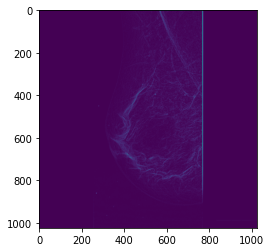

In [57]:
main('mdb001.png')

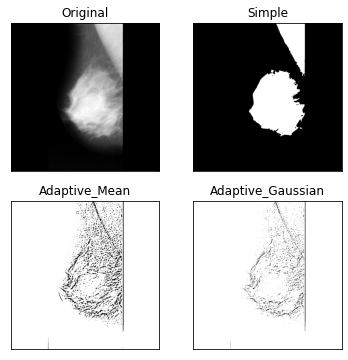

In [58]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('mdb001.png',0)
img = cv2.medianBlur(img,5)

ret,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

titles = ['Original','Simple','Adaptive_Mean','Adaptive_Gaussian']
images = [img,th1,th2,th3]

plt.figure(figsize=(6,6))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

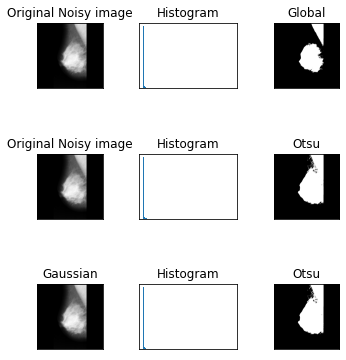

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

img = cv2.imread('mdb001.png',0)

ret1,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

blur = cv2.GaussianBlur(img,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)


titles = ['Original Noisy image','Histogram','Global',
          'Original Noisy image','Histogram','Otsu',
          'Gaussian','Histogram','Otsu']
images = [img,0,th1,
          img,0,th2,
          blur,0,th3]

plt.figure(figsize=(6,6))
for i in range(3):
    plt.subplot(3,3,i*3+1)
    plt.subplots_adjust(hspace=1)
    plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3])
    plt.xticks([])
    plt.yticks([])
    plt.subplot(3,3,i*3+2)
    plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1])
    plt.xticks([])
    plt.yticks([])
    plt.subplot(3,3,i*3+3)
    plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2])
    plt.xticks([])
    plt.yticks([])
plt.show()

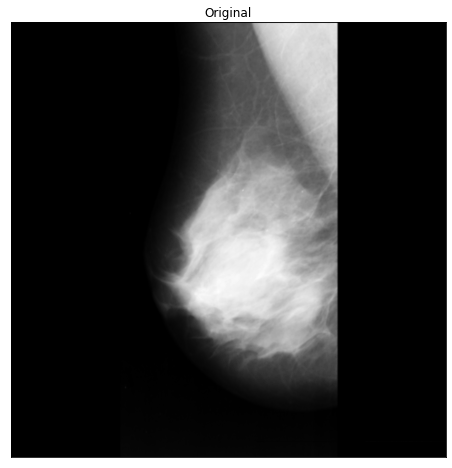

In [60]:
img = cv2.imread('mdb001.png',0)

kernel = np.ones((5,5),np.uint8)
gradiant = cv2.morphologyEx(img,cv2.MORPH_GRADIENT,kernel)

plt.figure(figsize=(10,8))
plt.imshow(img , cmap='gray',interpolation='bicubic')
plt.xticks([])
plt.yticks([])
plt.title("Original")
plt.show()

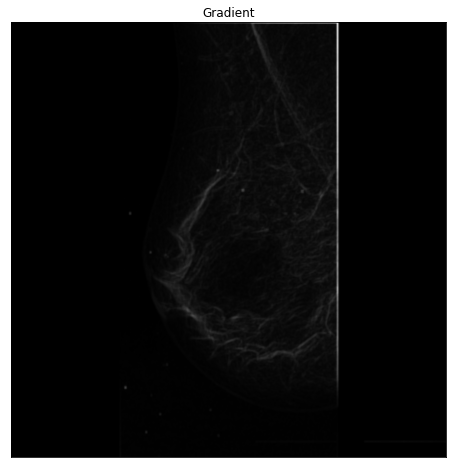

In [61]:
plt.figure(figsize=(10,8))
plt.imshow(gradiant , cmap='gray',interpolation='bicubic')
plt.xticks([])
plt.yticks([])
plt.title('Gradient')
plt.show()

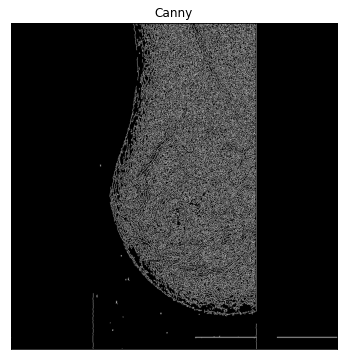

In [62]:
canny = cv2.Canny(img,5,10)

plt.figure(figsize=(8,6))
plt.imshow(canny,cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Canny')
plt.show()

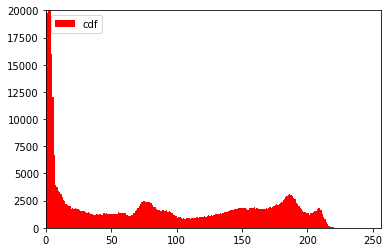

In [71]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('mdb001.png',0)

hist,bins = np.histogram(img.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

#plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.ylim([0,20000])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

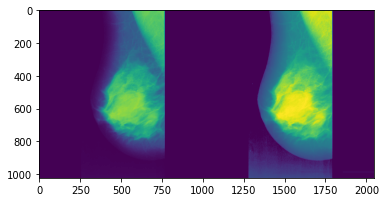

In [74]:
img = cv2.imread('mdb001.png',0)
equ = cv2.equalizeHist(img)
res = np.hstack((img,equ)) #stacking images side-by-side
plt.imshow(res)

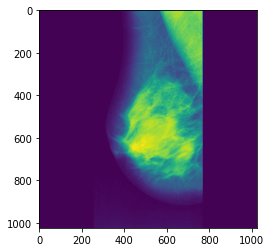

In [79]:
import numpy as np
import cv2

img = cv2.imread('mdb001.png',0)

# create a CLAHE object (Arguments are optional).
clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
cl1 = clahe.apply(img)

plt.imshow(cl1)

(1024, 1024)


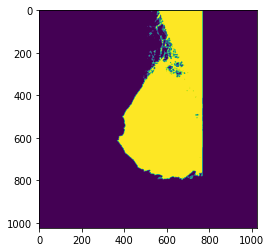

In [95]:
gray_image = cv2.imread('mdb001.png',0)
print(gray_image.shape)
ret,thresh1 = cv2.threshold(gray_image,0, 255,  cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.imshow(thresh1)

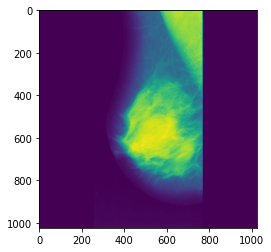

In [96]:
plt.imshow(gray_image)

In [105]:
import numpy as NP
import pandas as PD
import scipy.ndimage as NDI
import matplotlib as MP
import matplotlib.pyplot as MPP

import skimage as SKI
from skimage import io as SKIO
# import cv2 as CV

%matplotlib inline

def LoadImageFloat(filename, bits = 0):
    # image loading with bit conversion
    img = MPP.imread(filename) / 2**bits

    ## alternative:
    # img = SKI.img_as_float(SKIO.imread(filename)) / 2**bits

    return img

### remove axis labels from a matplotlib axis
def FullDespine(ax):

    ax.get_xaxis().set_tick_params(which='none')
    ax.get_yaxis().set_tick_params(which='none')
    ax.get_xaxis().set_tick_params(which='both', direction='out')
    ax.get_yaxis().set_tick_params(which='both', direction='out')

    ax.tick_params(top=False)
    ax.tick_params(right=False)
    ax.tick_params(left=False)
    ax.tick_params(right=False)

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xticks([])
    ax.set_yticks([])

def ConvertBits12to16(file_in, file_out):
    img = MPP.imread(file_in) / 2**12
    img = NP.array((img)*(2**16), dtype = NP.uint16)
    SKIO.imsave(file_out, img)

In [106]:
def ImageComparison(  image_list, n_cols = 4, dpi = 300, plot_args = dict(cmap = 'gray') \
                    , show_histogram = False, titles = None):
    ### plot multiple images side by side

    ## layout
    n_rows = (len(image_list)-1) // n_cols + 1
    n_cols = NP.min([len(image_list), n_cols])
    height_ratios = [1, 0.2]*n_rows if show_histogram else [1]*n_rows
    width_ratios = [1]*n_cols

    ## figure preparation
    cm = 1/2.54 # inch to cm conversion
    figwidth = 10 * cm
    fig = MPP.figure(  dpi = dpi \
                     , figsize = (figwidth, figwidth * NP.sum(height_ratios) / NP.sum(width_ratios) ) \
                     , facecolor = 'w')
    fig.subplots_adjust( \
                          top    = 1. \
                        , right  = 1. \
                        , bottom = 0. \
                        , left   = 0. \
                        , wspace = 0.00 # column spacing \
                        , hspace = 0.00 # row spacing \
                        )

    ## grid of images
    grid = MP.gridspec.GridSpec( \
                              n_rows * (2 if show_histogram else 1) \
                            , n_cols \
                            , height_ratios = height_ratios \
                            , width_ratios = width_ratios \
                            )

    ## plot images:
    for grid_idx, img in enumerate(image_list):
        col = (grid_idx) % n_cols
        row = (grid_idx // n_cols) * (2 if show_histogram else 1)

        ax = fig.add_subplot(grid[row, col], aspect = 'equal')

        ax.imshow(img, **plot_args)

        FullDespine(ax)

        if titles is not None:
            ax.set_title(titles[grid_idx], fontsize = 8)

        if show_histogram:
            # optionally show the histogram below the image
            ax = fig.add_subplot(grid[row+1, col], frameon=True, facecolor = (0.9,0.9,0.9))
            heights, _, _ = ax.hist(  img.ravel(), bins = 2**8 \
                                    , histtype='stepfilled', color= (0.2, 0.2, 0.6) \
                                    , density = True \
                                   )
            ax.set_ylim(NP.percentile(heights, [0, 98])*1.05)

            ax.set_xlim([0., 1.])
            FullDespine(ax)

    MPP.show();

In [107]:
img1 = LoadImageFloat('mdb001.png', bits = 16)

In [108]:
def Normalize(img):
    ### spread an image histogram over the bit range
    # print (NP.amin(img), NP.amax(img))
    img = img.copy()

    img = img - NP.amin(img) 
    img = img / NP.amax(img)
    # img = img % 1

    return img

def HistogramCut(img, shift = 0., cap = 1.):
    ### restrict the histogram to a rante between 'shift' and 'cap' 
    ## should be between 0. and 1., with shift < cap 
    img = img.copy()
    img[img>cap] = cap

    img -= shift
    img[img<0] = 0.

    img /= (cap-shift)

    return img

In [109]:
# example:
img1 = Normalize(img1.copy())
img1 = HistogramCut(img1.copy(), shift = 0.0, cap = 0.8)

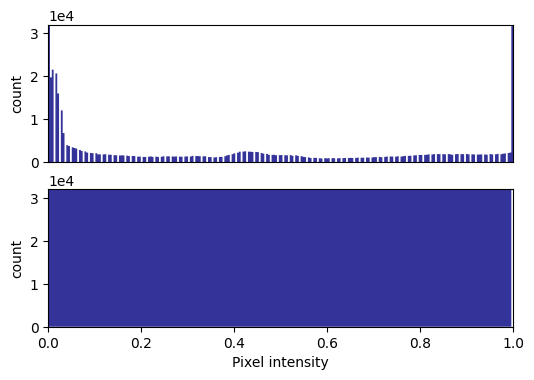

In [110]:
# Display histogram
fig = MPP.figure(dpi = 100, facecolor = 'w')

for nr, img in enumerate([img1, img2]):
    ax = fig.add_subplot(2,1,nr+1)
    ax.hist(img.ravel(), bins = 2**8, histtype='stepfilled', color= (0.2, 0.2, 0.6), density = False)
    ax.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    if nr == 1:
        ax.set_xlabel('Pixel intensity')

    else:
        ax.get_xaxis().set_visible(False)
    ax.set_ylabel('count')
    ax.set_ylim([0, 32000])
    ax.set_xlim(0., 1.)
MPP.show();

In [112]:
img_raw = NP.flipud(LoadImageFloat('mdb001.png', bits = 12))

image_chain = {'raw': img_raw.copy()}
img_current = img_raw.copy()

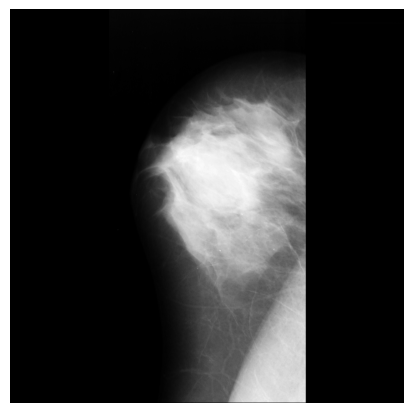

In [113]:
ImageComparison([img_raw], dpi = 100)

In [114]:
img_current = Normalize(SKI.exposure.adjust_log(img_raw.copy(), gain = 1., inv = False)) # explained below
blurred_image = NDI.filters.gaussian_filter(img_current, 32.)
edges = NP.subtract(img_current, blurred_image) / 2. + 0.5

##optional: add edges
edge_factor = 0.9
img_edged = Normalize(NP.add(img_current, edge_factor*edges)/(1.+edge_factor))

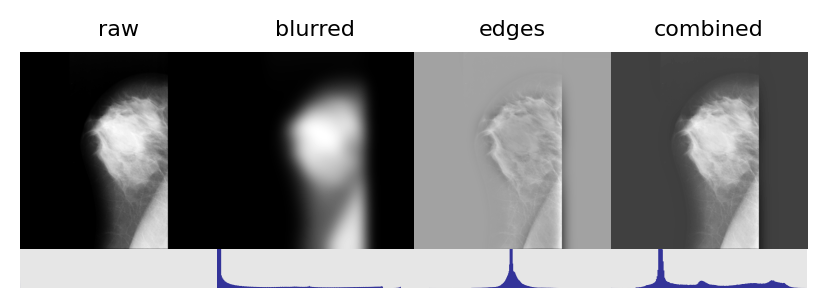

In [115]:
ImageComparison([image_chain['raw'], blurred_image, edges, img_edged], dpi = 200 \
                , show_histogram = True, titles = ['raw', 'blurred', 'edges', 'combined'])

In [116]:
img_current = img_edged.copy()
image_chain['edges'] = img_current

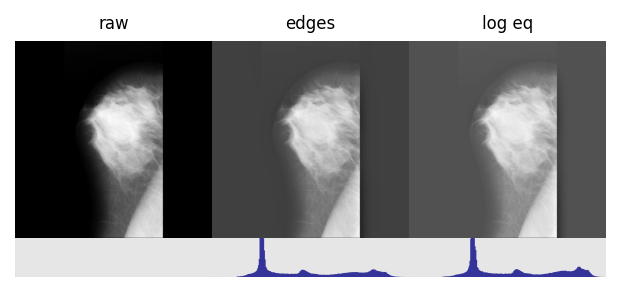

In [117]:
img_current = Normalize(SKI.exposure.adjust_log(img_current.copy(), gain = 4., inv = False))

image_chain['log eq'] = img_current.copy()
titles = ['raw', 'edges', 'log eq']
ImageComparison([image_chain[selection] for selection in titles], dpi = 150 \
                , show_histogram = True, titles = titles)

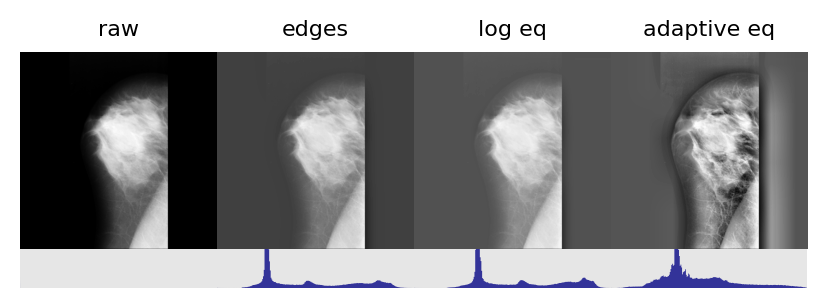

In [118]:
img_adapteq = SKI.exposure.equalize_adapthist(  img_current.copy() \
                                              #, kernel_size = 16**2
                                              #, nbins = 2**16 \
                                              , clip_limit = 0.02 \
                                             )
img_adapteq = Normalize(img_adapteq)
ImageComparison([image_chain[selection] for selection in titles] + [img_adapteq], dpi = 200 \
                , show_histogram = True, titles = titles + ['adaptive eq'])

In [119]:
image_chain['adaptive eq'] = SKI.img_as_float(img_adapteq).copy()

In [120]:
img_final = img_adapteq.copy()

# another global equalization
img_final = SKI.exposure.adjust_log(img_final, gain = 1., inv = False)

# cut the histogram
img_final = HistogramCut(img_final, 0.08, 0.98)
img_final = Normalize(img_final)

image_chain['final'] = img_final.copy()

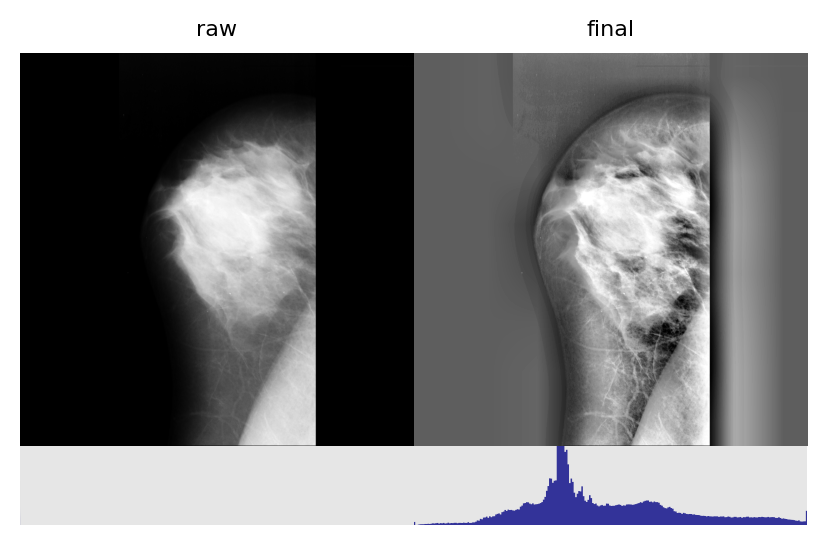

In [121]:
ImageComparison([img_raw, img_final], dpi = 200 \
                , show_histogram = True, titles =  ['raw', 'final'])

In [122]:
def DefaultImageManipulation(img_raw, edge_factor = 0., adaptive_eq_args = None):

    # initial equalization
    img = Normalize(SKI.exposure.adjust_log(img_raw.copy(), gain = 1., inv = False))

    # edge amplification
    blurred_image = NDI.filters.gaussian_filter(img, 32.)
    edges = Normalize(NP.subtract(img, blurred_image))

    img = Normalize(NP.add(img, edge_factor*edges)/(1.+edge_factor))

    # second equalization
    img = Normalize(SKI.exposure.adjust_log(img, gain = 4., inv = False))

    # adaptive equalization
    if adaptive_eq_args is not None:
        img = SKI.exposure.equalize_adapthist( img.copy(), **adaptive_eq_args )

    # another global equalization
    img = SKI.exposure.adjust_log(img, gain = 1., inv = False)

    # cut the histogram
    img = HistogramCut(img, 0.08, 0.98)
    img = HistogramCut(Normalize(img))

    return img

In [124]:
img_raw = LoadImageFloat('mdb001.png', bits = 16)
img_plain = DefaultImageManipulation(img_raw.copy(), edge_factor = 1.0 \
                                     , adaptive_eq_args = None)
img_adaptive = DefaultImageManipulation(img_raw.copy(), edge_factor = 1.0 \
                                     , adaptive_eq_args = dict(clip_limit = 0.02))

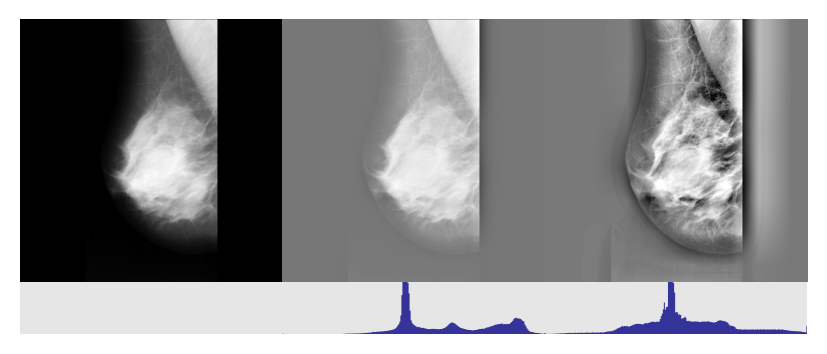

In [125]:
ImageComparison([img_raw, img_plain, img_adaptive], dpi = 200 \
                , show_histogram = True)